# Predicting Next Transaction Date

1.   Covert the date pameter
2.   Calculate the Total Sale per each invoice
3.  RFM Segmentation
*   Recency Cluster
*   Frequency Cluster
*   Monitory Cluster


4. Setting overall score
5. Data normalization
6. Encoding independant variable
7. Model Devlopemt



In [1]:
# importing necessary Python libraries
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import plotly.express as px
#import plotly.offline as pyoff
import plotly.graph_objs as go 
#import plotly.figure_factory as ff

# avoid displaying warnings
import warnings
warnings.filterwarnings("ignore")

#import machine learning related libraries
from sklearn.svm import SVC
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold, cross_val_score, train_test_split, GridSearchCV, cross_validate
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
from sklearn.cluster import KMeans
import xgboost as xgb
import time

from sklearn.preprocessing import MinMaxScaler

# Loading the data
df = pd.read_csv('online_retail_II.csv',encoding='latin1')
# Rename the following columns: 
#    Invoice to InvoiceNo
#    Customer ID to CustomerID
#    Price to UnitPrice

df.rename(columns={'Invoice':'InvoiceNo', 'Customer ID':'CustomerID', 'Price':'UnitPrice'}, inplace=True)

df_data = df.dropna()
df_data.InvoiceDate = pd.to_datetime(df_data.InvoiceDate)
df_data['InvoiceYearMonth'] = df_data['InvoiceDate'].map(lambda date: 100*date.year + date.month)
df_data['Revenue'] = df_data.UnitPrice * df_data.Quantity
ctm_revenue = df_data.groupby('InvoiceYearMonth').Revenue.sum().reset_index()

ctm_bhvr_dt = df_data[(df_data.InvoiceDate < pd.Timestamp(2011,9,1)) & 
      (df_data.InvoiceDate >= pd.Timestamp(2009,12,1))].reset_index(drop=True)


ctm_next_quarter = df_data[(df_data.InvoiceDate < pd.Timestamp(2011,12,1)) & 
      (df_data.InvoiceDate >= pd.Timestamp(2011,9,1))].reset_index(drop=True)

# Get the distinct customers in the dataframe ctm_bhvr_dt
ctm_dt = pd.DataFrame(ctm_bhvr_dt['CustomerID'].unique())

# Rename the column to CustomerID.
ctm_dt.columns = ['CustomerID']

# Create a dataframe with CustomerID and customers first purchase 
# date in ctm_next_quarter
ctm_1st_purchase_in_next_quarter = ctm_next_quarter.groupby('CustomerID').InvoiceDate.min().reset_index()
ctm_1st_purchase_in_next_quarter.columns = ['CustomerID','MinPurchaseDate']

ctm_last_purchase_bhvr_dt = ctm_bhvr_dt.groupby('CustomerID').InvoiceDate.max().reset_index()
ctm_last_purchase_bhvr_dt.columns = ['CustomerID','MaxPurchaseDate']

# Merge two dataframes ctm_last_purchase_bhvr_dt and ctm_1st_purchase_in_next_quarter
ctm_purchase_dates = pd.merge(ctm_last_purchase_bhvr_dt, ctm_1st_purchase_in_next_quarter, on='CustomerID', 
                              how='left')

ctm_purchase_dates['NextPurchaseDay'] = (ctm_purchase_dates['MinPurchaseDate'] - ctm_purchase_dates['MaxPurchaseDate']).dt.days

# merge with ctm_dt 
ctm_dt = pd.merge(ctm_dt, ctm_purchase_dates[['CustomerID','NextPurchaseDay']], on='CustomerID', how='left')

ctm_dt = ctm_dt.fillna(9999)

ctm_max_purchase = ctm_bhvr_dt.groupby('CustomerID').InvoiceDate.max().reset_index()
ctm_max_purchase.columns = ['CustomerID','MaxPurchaseDate']

# Find the recency in days 
ctm_max_purchase['Recency'] = (ctm_max_purchase['MaxPurchaseDate'].max() - ctm_max_purchase['MaxPurchaseDate']).dt.days

# Merge the dataframes ctm_dt and ctm_max_purchase[['CustomerID', 'Recency']] on the CustomerID column.
ctm_dt = pd.merge(ctm_dt, ctm_max_purchase[['CustomerID', 'Recency']], on='CustomerID')

number_of_clusters = 4

kmeans = KMeans(n_clusters=number_of_clusters)
kmeans.fit(ctm_dt[['Recency']])
ctm_dt['RecencyCluster'] = kmeans.predict(ctm_dt[['Recency']])

def order_cluster(df, target_field_name, cluster_field_name, ascending):
    """
    INPUT:
        - df                  - pandas DataFrame
        - target_field_name   - str - A column in the pandas DataFrame df
        - cluster_field_name  - str - Expected to be a column in the pandas DataFrame df
        - ascending           - Boolean
        
    OUTPUT:
        - df_final            - pandas DataFrame with target_field_name and cluster_field_name as columns
    
    """
    # Add the string "new_" to cluster_field_name
    new_cluster_field_name = "new_" + cluster_field_name
    
    # Create a new dataframe by grouping the input dataframe by cluster_field_name and extract target_field_name 
    # and find the mean
    df_new = df.groupby(cluster_field_name)[target_field_name].mean().reset_index()
    
    # Sort the new dataframe df_new, by target_field_name in descending order
    df_new = df_new.sort_values(by=target_field_name, ascending=ascending).reset_index(drop=True)
    
    # Create a new column in df_new with column name index and assign it values to df_new.index
    df_new["index"] = df_new.index
    
    # Create a new dataframe by merging input dataframe df and part of the columns of df_new based on 
    # cluster_field_name
    df_final = pd.merge(df, df_new[[cluster_field_name, "index"]], on=cluster_field_name)
    
    # Update the dataframe df_final by deleting the column cluster_field_name
    df_final = df_final.drop([cluster_field_name], axis=1)
    
    # Rename the column index to cluster_field_name
    df_final = df_final.rename(columns={"index": cluster_field_name})
    
    return df_final

ctm_dt = order_cluster(ctm_dt, 'Recency', 'RecencyCluster', False)

#get order counts for each user and create a dataframe with it
ctm_frequency = df_data.groupby('CustomerID').InvoiceDate.count().reset_index()
ctm_frequency.columns = ['CustomerID','Frequency']

#add this data to our main ctm_dt
ctm_dt = pd.merge(ctm_dt, ctm_frequency, on='CustomerID')

kmeans = KMeans(n_clusters=number_of_clusters)
kmeans.fit(ctm_dt[['Frequency']])
ctm_dt['FrequencyCluster'] = kmeans.predict(ctm_dt[['Frequency']])

ctm_dt = order_cluster(ctm_dt, 'Frequency', 'FrequencyCluster', False)

ctm_revenue = df_data.groupby('CustomerID').Revenue.sum().reset_index()

#merge it with our ctm_dt
ctm_dt = pd.merge(ctm_dt, ctm_revenue, on='CustomerID')

#apply clustering
kmeans = KMeans(n_clusters=number_of_clusters)
kmeans.fit(ctm_dt[['Revenue']])
ctm_dt['RevenueCluster'] = kmeans.predict(ctm_dt[['Revenue']])

#order the cluster numbers
ctm_dt = order_cluster(ctm_dt, 'Revenue', 'RevenueCluster', True)

#calculate overall score and use mean() to see details
ctm_dt['OverallScore'] = ctm_dt['RecencyCluster'] + ctm_dt['FrequencyCluster'] + ctm_dt['RevenueCluster']
ctm_dt.groupby('OverallScore')['Recency','Frequency','Revenue'].mean()

ctm_dt['Segment'] = 'Low-Value'
ctm_dt.loc[ctm_dt['OverallScore'] > 4, 'Segment'] = 'Mid-Value'
ctm_dt.loc[ctm_dt['OverallScore'] > 6, 'Segment'] = 'High-Value'

#create ctm_class as a copy of ctm_dt before applying get_dummies
ctm_class = ctm_dt.copy()
ctm_class = pd.get_dummies(ctm_class)
ctm_class.head()

# ctm_class['NextPurchaseDayRange'] = 4  ## first week
# ctm_class.loc[ctm_class.NextPurchaseDay>7,'NextPurchaseDayRange'] = 3 # second week
# ctm_class.loc[ctm_class.NextPurchaseDay>14,'NextPurchaseDayRange'] = 2 # 3rd week
# ctm_class.loc[ctm_class.NextPurchaseDay>30,'NextPurchaseDayRange'] = 1 # 4th week
# ctm_class.loc[ctm_class.NextPurchaseDay>90,'NextPurchaseDayRange'] = 0 # more than 3 months

# corr_matrix = ctm_class[ctm_class.columns].corr()
# corr_df = pd.DataFrame(corr_matrix.min())
# corr_df.columns = ['MinCorrelationCoeff']
# corr_df['MaxCorrelationCoeff'] = corr_matrix[corr_matrix < 1].max()

ctm_class.head()




,CustomerID,NextPurchaseDay,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue,RevenueCluster,OverallScore,Segment_High-Value,Segment_Low-Value,Segment_Mid-Value
0,13085.0,9999.0,57,3,92,3,1459.46,0,6,0,0,1
1,18087.0,46.0,44,3,95,3,14411.62,0,6,0,0,1
2,17519.0,116.0,33,3,224,3,5102.80,0,6,0,0,1
3,12362.0,40.0,12,3,275,3,5284.58,0,6,0,0,1
4,15712.0,38.0,9,3,167,3,3467.46,0,6,0,0,1


In [2]:
ctm_class['NextPurchaseDayRange'] = 2  ## first week
ctm_class.loc[ctm_class.NextPurchaseDay>30,'NextPurchaseDayRange'] = 1 # 4th week
ctm_class.loc[ctm_class.NextPurchaseDay>90,'NextPurchaseDayRange'] = 0 # more than 3 months
ctm_class.head()

,CustomerID,NextPurchaseDay,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue,RevenueCluster,OverallScore,Segment_High-Value,Segment_Low-Value,Segment_Mid-Value,NextPurchaseDayRange
0,13085.0,9999.0,57,3,92,3,1459.46,0,6,0,0,1,0
1,18087.0,46.0,44,3,95,3,14411.62,0,6,0,0,1,1
2,17519.0,116.0,33,3,224,3,5102.80,0,6,0,0,1,0
3,12362.0,40.0,12,3,275,3,5284.58,0,6,0,0,1,1
4,15712.0,38.0,9,3,167,3,3467.46,0,6,0,0,1,1


In [3]:
from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
ctm_class = ctm_class.drop('NextPurchaseDay', axis=1)
ctm_class = ctm_class.drop('CustomerID', axis=1)
X, y = ctm_class.drop('NextPurchaseDayRange',axis=1), ctm_class.NextPurchaseDayRange
# y = to_categorical(y)

# encode class values as integers
encoder = LabelEncoder()
encoder.fit(y)
y = encoder.transform(y)

# convert integers to dummy variables (i.e. one hot encoded)
y = to_categorical(y)

sc = MinMaxScaler(feature_range=(0, 1))
X = sc.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=44)

In [4]:
import keras.backend as K
K.clear_session()

In [5]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
# Define the model
model = Sequential()
model.add(Dense(64, input_shape = (10,), activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(16, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(3, activation='sigmoid'))


model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])

In [6]:
# Train the model
model.fit(X_train,y_train,batch_size = 16,
          epochs=50,
          validation_data=(X_test, y_test))

Epoch 1/50
266/266 [==============================] - 1s 3ms/step - loss: 0.5019 - accuracy: 0.8109 - val_loss: 0.3641 - val_accuracy: 0.8363
Epoch 2/50
266/266 [==============================] - 0s 2ms/step - loss: 0.3331 - accuracy: 0.8342 - val_loss: 0.3219 - val_accuracy: 0.8260
Epoch 3/50
266/266 [==============================] - 0s 2ms/step - loss: 0.3133 - accuracy: 0.8393 - val_loss: 0.3187 - val_accuracy: 0.8401
Epoch 4/50
266/266 [==============================] - 0s 2ms/step - loss: 0.3015 - accuracy: 0.8445 - val_loss: 0.3008 - val_accuracy: 0.8382
Epoch 5/50
266/266 [==============================] - 0s 2ms/step - loss: 0.3011 - accuracy: 0.8485 - val_loss: 0.2960 - val_accuracy: 0.8354
Epoch 6/50
266/266 [==============================] - 0s 2ms/step - loss: 0.2945 - accuracy: 0.8504 - val_loss: 0.3015 - val_accuracy: 0.8420
Epoch 7/50
266/266 [==============================] - 0s 2ms/step - loss: 0.2903 - accuracy: 0.8530 - val_loss: 0.3018 - val_accuracy: 0.8420
Epoch 

In [7]:
eval_model = model.evaluate(X_train, y_train)
eval_model

133/133 [==============================] - 0s 1ms/step - loss: 0.2710 - accuracy: 0.8579


[0.2710111141204834, 0.8579157590866089]

In [8]:
pred= model.predict(X_test)
pred

34/34 [==============================] - 0s 1ms/step


array([[9.9918675e-01, 1.1319174e-02, 6.4737373e-12],
       [1.0000000e+00, 1.7345632e-05, 1.3139572e-25],
       [9.9999988e-01, 1.5663643e-05, 7.8363353e-26],
       ...,
       [1.0000000e+00, 3.0590861e-08, 0.0000000e+00],
       [1.0000000e+00, 8.6334246e-08, 1.0231758e-37],
       [9.9999994e-01, 1.3151079e-05, 3.2291670e-26]], dtype=float32)

In [9]:
# Get the class labels by finding the index of the highest predicted probability
y_pred_labels = np.argmax(pred, axis=1)

# Convert the encoded labels back to the original labels
y_pred_labels = encoder.inverse_transform(y_pred_labels)

# Create a dataframe with the predicted labels
predictions_df = pd.DataFrame({'Predicted_NextPurchaseDayRange': y_pred_labels})


# predictions_df.tail(50)
y_pred_labels[1]

0

In [10]:
y_test[1]

array([1., 0., 0.], dtype=float32)

In [11]:
rounded_labels=np.argmax(y_test, axis=1)
rounded_labels[1]
# 2

0

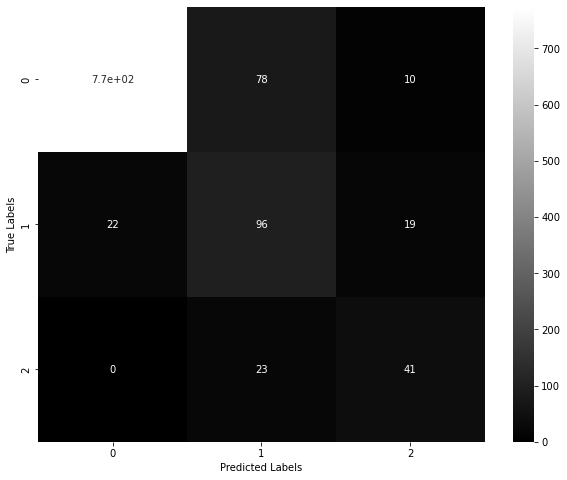

In [12]:
from sklearn import metrics
import matplotlib.cm as cm

plt.figure(figsize = (10,8))
sns.heatmap(metrics.confusion_matrix(rounded_labels, y_pred_labels), annot = True, cmap = cm.gray)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [13]:
from sklearn.metrics import classification_report

print(classification_report(rounded_labels, y_pred_labels))

              precision    recall  f1-score   support

           0       0.97      0.90      0.93       862
           1       0.49      0.70      0.57       137
           2       0.59      0.64      0.61        64

    accuracy                           0.86      1063
   macro avg       0.68      0.75      0.71      1063
weighted avg       0.89      0.86      0.87      1063



In [ ]:
from sklearn.metrics import roc_auc_score

# Generate class membership probabilities
y_preb_probs = clf.predict_proba(X_test)
roc_auc_score(y_test, y_preb_probs, average="weighted", multi_class="ovr")

In [ ]:
predictions_df['Predicted_NextPurchaseDayRange'].unique()

array([0, 1, 2, 4])

In [ ]:
import joblib
joblib.dump(model,'txnDayPredictionModel.sav')

['txnDayPredictionModel.sav']

In [ ]:
df_pred = pd.DataFrame({'Predicted_NextPurchaseDayRange': y_pred_labels})
for i, col in enumerate(ctm_class.columns[:-1]):
  df_pred[col] = X_test[:,i]

In [ ]:
df_pred.head()

,Predicted_NextPurchaseDayRange,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue,RevenueCluster,OverallScore,Segment_High-Value,Segment_Low-Value,Segment_Mid-Value
0,0,0.277429,0.666667,0.001222,1.0,0.040547,0.0,0.4,0.0,0.0,1.0
1,0,0.568966,0.333333,0.002138,1.0,0.042994,0.0,0.2,0.0,1.0,0.0
2,0,0.539185,0.333333,0.001145,1.0,0.040286,0.0,0.2,0.0,1.0,0.0
3,0,0.333856,0.666667,0.010003,1.0,0.042058,0.0,0.4,0.0,0.0,1.0
4,0,0.485893,0.333333,0.000764,1.0,0.040649,0.0,0.2,0.0,1.0,0.0
